# Project 8: Credit Card Fraud Detection

**Type:** Classification | **Level:** Advanced

Detect fraudulent credit card transactions using imbalanced dataset techniques.

**Model:** Random Forest Classifier with SMOTE

**Dataset:** [Kaggle Fraud Detection](https://www.kaggle.com/datasets/kartik2112/fraud-detection/data)

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load the dataset
df_train = pd.read_csv('../data/credit_card_fraud/fraudTrain.csv')
df_test = pd.read_csv('../data/credit_card_fraud/fraudTest.csv')

print(f"Training dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")
print(f"\nColumn names:\n{df_train.columns.tolist()}")
print(f"\nFirst few rows:")
df_train.head()

Training dataset shape: (1296675, 23)
Test dataset shape: (555719, 23)

Column names:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

First few rows:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## 3. Exploratory Data Analysis

Dataset Info:
Rows: 1296675, Columns: 23

Data types:
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

Missing values: 0

Class distribution (is_fraud):
is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Fraud percentage: 0.58%


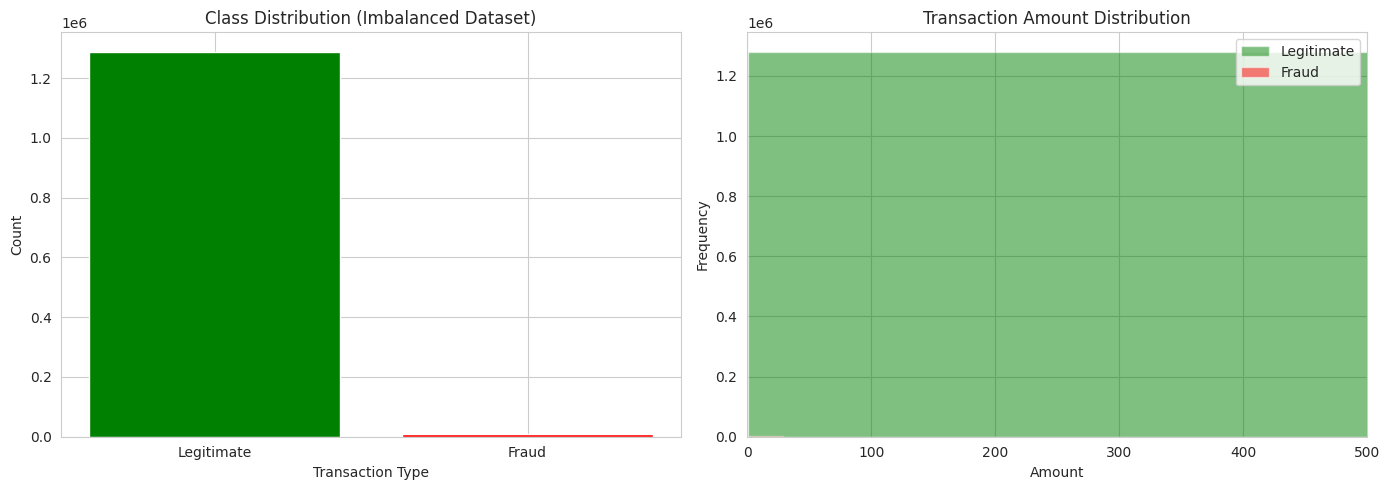

In [3]:
# Basic info
print("Dataset Info:")
print(f"Rows: {df_train.shape[0]}, Columns: {df_train.shape[1]}")
print(f"\nData types:\n{df_train.dtypes}")
print(f"\nMissing values: {df_train.isnull().sum().sum()}")
print(f"\nClass distribution (is_fraud):")
print(df_train['is_fraud'].value_counts())
print(f"\nFraud percentage: {df_train['is_fraud'].mean() * 100:.2f}%")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
fraud_counts = df_train['is_fraud'].value_counts()
axes[0].bar(['Legitimate', 'Fraud'], fraud_counts.values, color=['green', 'red'])
axes[0].set_title('Class Distribution (Imbalanced Dataset)')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Transaction Type')

# Transaction amount distribution by fraud status
axes[1].hist(df_train[df_train['is_fraud']==0]['amt'], bins=50, alpha=0.5, label='Legitimate', color='green')
axes[1].hist(df_train[df_train['is_fraud']==1]['amt'], bins=50, alpha=0.5, label='Fraud', color='red')
axes[1].set_title('Transaction Amount Distribution')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].set_xlim(0, 500)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [4]:
# Select relevant features for modeling
# Drop unnecessary columns (ID columns, timestamps, personal info)
columns_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 
                   'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 
                   'trans_num', 'unix_time']

df_processed = df_train.drop(columns=columns_to_drop)

# Convert categorical variables to numeric using one-hot encoding
categorical_cols = ['category', 'gender', 'job']
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"Processed dataset shape: {df_processed.shape}")
print(f"\nFeatures after preprocessing: {df_processed.columns.tolist()}")

# Separate features and target
X = df_processed.drop('is_fraud', axis=1)
y = df_processed['is_fraud']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution before SMOTE:")
print(y.value_counts())

Processed dataset shape: (1296675, 514)

Features after preprocessing: ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'gender_M', 'job_Accountant, chartered', 'job_Accountant, chartered certified', 'job_Accountant, chartered public finance', 'job_Accounting technician', 'job_Acupuncturist', 'job_Administrator', 'job_Administrator, arts', 'job_Administrator, charities/voluntary organisations', 'job_Administrator, education', 'job_Administrator, local government', 'job_Advertising account executive', 'job_Advertising account planner', 'job_Advertising copywriter', 'job_Advice worker', 'job_Aeronautical engineer', 'job_Agricultural consultant', 'job_Aid worker', 'job

## 5. Model Training

In [5]:
# Use only a subset of data to avoid memory issues
print("Sampling data for faster training...")
sample_size = 100000  # Use 100k samples instead of full dataset
if len(X) > sample_size:
    X_sample = X.sample(n=sample_size, random_state=42)
    y_sample = y[X_sample.index]
else:
    X_sample = X
    y_sample = y

print(f"Using {len(X_sample)} samples for training")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Class distribution in training:")
print(y_train.value_counts())

# Apply SMOTE with sampling_strategy to limit synthetic samples
print("\nApplying SMOTE to balance the dataset...")
smote = SMOTE(
    sampling_strategy=0.5,  # Create fraud samples to be 50% of legitimate
    random_state=42,
    k_neighbors=5
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Train Random Forest with reduced parameters
print("\nTraining Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=50,      # Reduced from 100
    max_depth=10,         # Limit tree depth
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
model.fit(X_train_balanced, y_train_balanced)

print("\nModel training completed!")

Sampling data for faster training...
Using 100000 samples for training

Training set size: 80000
Validation set size: 20000
Class distribution in training:
is_fraud
0    79522
1      478
Name: count, dtype: int64

Applying SMOTE to balance the dataset...

Class distribution after SMOTE:
is_fraud
0    79522
1    39761
Name: count, dtype: int64

Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s



Model training completed!


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished


## 6. Model Evaluation

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     19880
       Fraud       0.39      0.47      0.43       120

    accuracy                           0.99     20000
   macro avg       0.69      0.74      0.71     20000
weighted avg       0.99      0.99      0.99     20000


ROC-AUC Score: 0.8999
Precision-Recall AUC: 0.3400


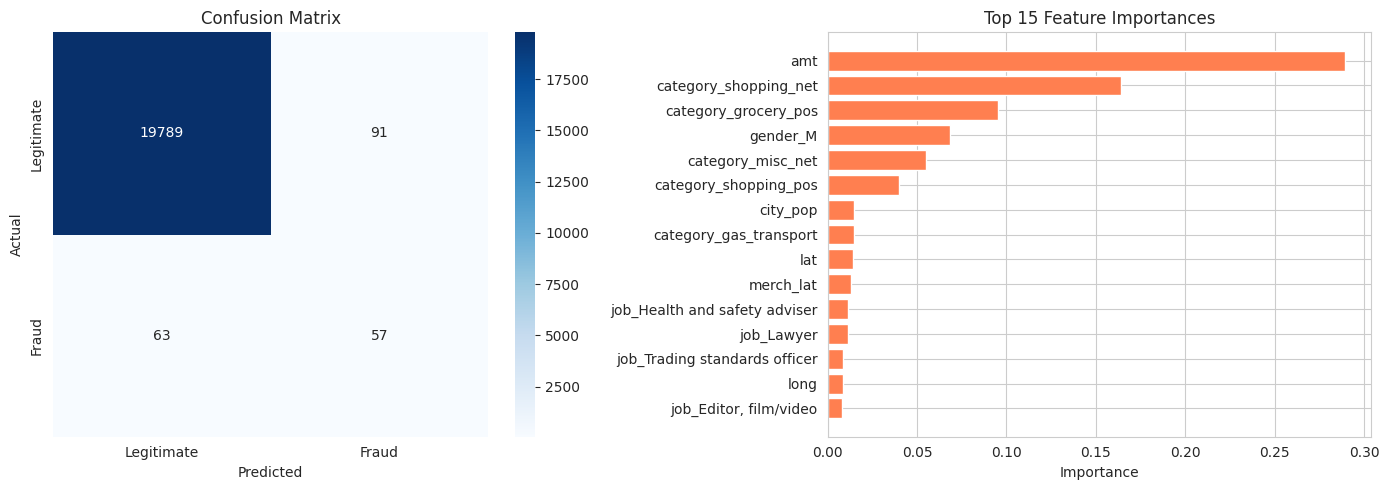

In [6]:
# Make predictions on validation set
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate metrics
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Legitimate', 'Fraud']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Precision-Recall AUC (better for imbalanced datasets)
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0].set_yticklabels(['Legitimate', 'Fraud'])

# Feature Importance (top 15)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(range(len(feature_importance)), feature_importance['importance'].values, color='coral')
axes[1].set_yticks(range(len(feature_importance)))
axes[1].set_yticklabels(feature_importance['feature'].values)
axes[1].set_title('Top 15 Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Save Model

In [7]:
# Save the trained model
model_path = '../models/credit_card_fraud_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# Save feature names for future predictions
feature_data = {
    'feature_names': X.columns.tolist(),
    'categorical_columns': categorical_cols
}
joblib.dump(feature_data, '../models/credit_card_fraud_features.pkl')
print("Feature data saved!")

# Print final metrics summary
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print("\nThis model uses SMOTE to handle class imbalance")
print("and Random Forest for robust fraud detection.")

Model saved to: ../models/credit_card_fraud_model.pkl
Feature data saved!

MODEL PERFORMANCE SUMMARY
ROC-AUC Score: 0.8999
Precision-Recall AUC: 0.3400

This model uses SMOTE to handle class imbalance
and Random Forest for robust fraud detection.
